## Setting Up

In [1]:
!pip install fuzzywuzzy

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt
import charset_normalizer
from google.colab import userdata
import os
import pandas as pd
import numpy as np
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d kemical/kickstarter-projects
!kaggle datasets download -d maxhorowitz/nflplaybyplay2009to2016
!kaggle datasets download -d nasa/landslide-events

Dataset URL: https://www.kaggle.com/datasets/kemical/kickstarter-projects
License(s): CC-BY-NC-SA-4.0
 90% 33.0M/36.8M [00:00<00:00, 52.9MB/s]
100% 36.8M/36.8M [00:00<00:00, 50.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016
License(s): unknown
 99% 271M/274M [00:04<00:00, 51.1MB/s]
100% 274M/274M [00:04<00:00, 70.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/nasa/landslide-events
License(s): CC0-1.0
  0% 0.00/128k [00:00<?, ?B/s]
100% 128k/128k [00:00<00:00, 30.1MB/s]


In [5]:
!mkdir "/content/Dataset"
!unzip "/content/kickstarter-projects.zip" -d "/content/Dataset"
!unzip "/content/landslide-events.zip" -d "/content/Dataset"
!unzip "/content/nflplaybyplay2009to2016.zip" -d "/content/Dataset"

Archive:  /content/kickstarter-projects.zip
  inflating: /content/Dataset/ks-projects-201612.csv  
  inflating: /content/Dataset/ks-projects-201801.csv  
Archive:  /content/landslide-events.zip
  inflating: /content/Dataset/catalog.csv  
Archive:  /content/nflplaybyplay2009to2016.zip
  inflating: /content/Dataset/NFL Play by Play 2009-2016 (v3).csv  
  inflating: /content/Dataset/NFL Play by Play 2009-2017 (v4).csv  
  inflating: /content/Dataset/NFL Play by Play 2009-2018 (v5).csv  



## Handling Missing Values

Find why the data is missing?

- data does not exist => just leave NaN as it is

- data was not recoreded => fill the NaN values

1. Identify missing data

2. Decide on approach:

   a) NaN because data does not exist:
      - Leave as is or remove some rows/columns
      - Drop specific columns: df.drop(['column1', 'column2'], axis=1)
      - Drop specific rows: df.drop([0, 1, 2], axis=0)
      - Drop all columns with NaNs: df.dropna(axis=1)
      - Drop all rows with NaNs: df.dropna(axis=0)

   b) Data was not recorded:
  - Fill with a specific value: df.fillna(0)
  - fill using bakward fill: df.fillna(method='bfill', axis=0) # do the operation row by row from top to bottom
   - fill using forward fill: df.fillna(method=‘ffill', axis=0) # do the operation row by row from bottom to top
  - Fill with mean/median: df['column'].fillna(df['column'].mean())

3. Additional methods:
   - Interpolation: df.interpolate() # by default axis is 0
   - Forward fill: df.ffill() # by default it applies ffill() by axis=0 on every columns
   - Backward fill: df.bfill() # by default it applies bfill() by axis=0 on every columns
  


In [23]:
df = pd.read_csv('/content/Dataset/NFL Play by Play 2009-2017 (v4).csv')
df.head()

<ipython-input-23-9ac090ba0cf3>:1: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Dataset/NFL Play by Play 2009-2017 (v4).csv')


,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


In [24]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

In [25]:
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

percentage = total_missing / total_cells * 100
print(percentage)

27.66722370547874


### Dropping Missing Values

Option1: Drop all rows if any value in the row has NaN value

In [26]:
rows_with_na_dropped = df.dropna(axis=0)
rows_with_na_dropped.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


Option2: Drop all columns if any value has NaN Value

In [27]:
columns_with_na_dropped = df.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,AwayTeam,Timeout_Indicator,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009


### Fill the missing values

In [28]:
subset_nfl_data = df.loc[:, "EPA":'Season'].head()
subset_nfl_data

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


In [29]:
# replace all NA's with 0
subset_nfl_data.fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,0.000000,0.000000,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.000000,0.000000,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


In [30]:
# replace all NA's the value that comes directly after it in the same column,
# then replace all the remaining na's with 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,-1.068169,1.146076,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,-0.032244,0.036899,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,3.318841,-5.031425,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.106663,-0.156239,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


## Scaling and Normalization

- scaling, you're changing the range of your data. For example sacaling image tensors to [0,1]
- normalization, you're changing distribution of the data.

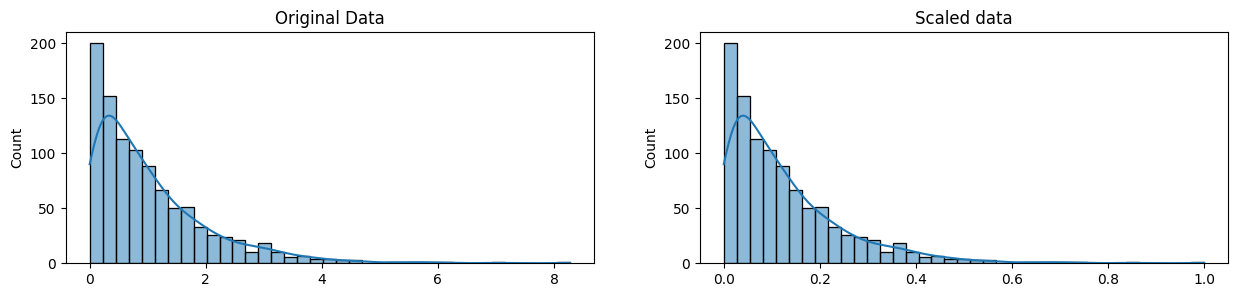

In [31]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size=1000)

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(original_data, columns=[0])

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

sns.histplot(original_data, ax=ax[0], kde=True, legend=True)
ax[0].set_title("Original Data")

sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")

plt.show()

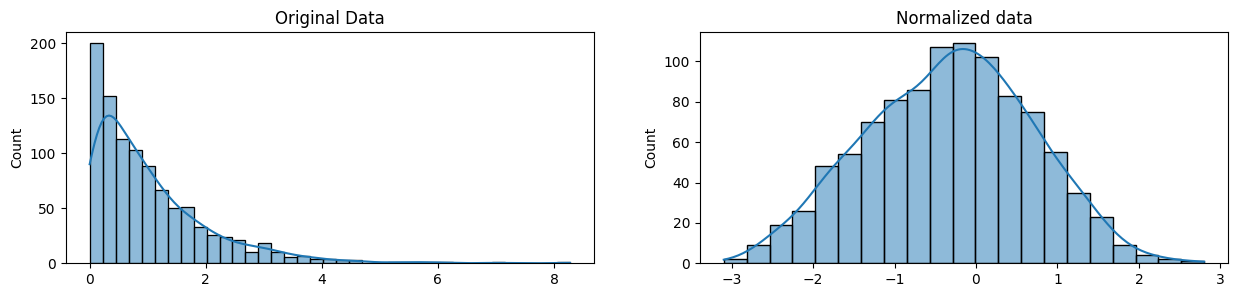

In [32]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(original_data)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))

sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")

sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

## Parsing Dates

If you cehck the dtype of the date column, you can find its dtype is `object`. (Pandas uses the `object` dtype for storing various types of data types, but most often when you see a column with the dtype `object` it will have strings in it.) But as Python doesn't know what this column is when its dtype is `object`, we gonna change it to `datetime64`.

1. Convert strings to datetime:
df['date'] = pd.to_datetime(df['date'])

2. Specify date format if needed:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
Common format codes:

- %d: day
- %m: month
- %y: two-digit year
- %Y: four-digit year


3. Access date components:
```
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
```

4. Other useful datetime attributes:
```
.dt.weekday
.dt.quarter
.dt.dayofyear
```

In [33]:
df = pd.read_csv('/content/Dataset/catalog.csv')

In [34]:
df.head()

,id,date,time,continent_code,country_name,country_code,state/province,population,city/town,distance,...,geolocation,hazard_type,landslide_type,landslide_size,trigger,storm_name,injuries,fatalities,source_name,source_link
0,34,3/2/07,Night,NaN,United States,US,Virginia,16000,Cherry Hill,3.40765,...,"(38.600900000000003, -77.268199999999993)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,NBC 4 news,http://www.nbc4.com/news/11186871/detail.html
1,42,3/22/07,NaN,NaN,United States,US,Ohio,17288,New Philadelphia,3.33522,...,"(40.517499999999998, -81.430499999999995)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,Canton Rep.com,http://www.cantonrep.com/index.php?ID=345054&C...
2,56,4/6/07,NaN,NaN,United States,US,Pennsylvania,15930,Wilkinsburg,2.91977,...,"(40.4377, -79.915999999999997)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,The Pittsburgh Channel.com,https://web.archive.org/web/20080423132842/htt...
3,59,4/14/07,NaN,NaN,Canada,CA,Quebec,42786,Châteauguay,2.98682,...,"(45.322600000000001, -73.777100000000004)",Landslide,Riverbank collapse,Small,Rain,NaN,NaN,NaN,Le Soleil,http://www.hebdos.net/lsc/edition162007/articl...
4,61,4/15/07,NaN,NaN,United States,US,Kentucky,6903,Pikeville,5.66542,...,"(37.432499999999997, -82.493099999999998)",Landslide,Landslide,Small,Downpour,NaN,NaN,0.0,Matthew Crawford (KGS),NaN


In [35]:
df['date'].head()

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object

Pandas uses the "object" dtype for storing various types of data types, but most often when you see a column with the dtype "object" it will have strings in it.

In [36]:
df['date'].dtype

dtype('O')

`%d` for day, `%m` for month, `%y` for a two-digit year and `%Y` for a four digit year.

In [37]:
df['date_parsed'] = pd.to_datetime(df['date'], format="%m/%d/%y")

What if I run into an error with multiple date formats? While we're specifying the date format here, sometimes you'll run into an error when there are multiple date formats in a single column. If that happens, you can have pandas try to infer what the right date format should be. You can do that like so:
landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)

Why don't you always use infer_datetime_format = True? There are two big reasons not to always have pandas guess the time format. The first is that pandas won't always been able to figure out the correct date format, especially if someone has gotten creative with data entry. The second is that it's much slower than specifying the exact format of the dates.

In [38]:
df['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

In [40]:
day_of_month_landslides = df['date_parsed'].dt.day
day_of_month_landslides.head()

0     2.0
1    22.0
2     6.0
3    14.0
4    15.0
Name: date_parsed, dtype: float64

## Character Encoding

1. Definition:
   Character encoding is a system that maps bytes to human-readable characters.

2. Encoding and Decoding:
   - Encode: Convert human-readable text to bytes
   - Decode: Convert bytes to human-readable text

3. Consistency:
   Use the same encoding for both encoding and decoding to avoid errors.

   ```
   # Encoding
   byte_string = text.encode('utf-8')
   
   # Decoding
   text = byte_string.decode('utf-8')
   ```


4. Byte Strings:
   Represented in Python as b'some text'

5. Detecting Encoding:

Nowadays, UTF-8 is the most common encoding method used. Usually, you can simply do:
df = pd.read_csv(file_path) # by default UTF-8 is used.

However, sometimes this might raise a UnicodeDecodeError. In such cases, you'll need to detect the file's encoding using charset_normalizer to guess the encoding:

```
from charset_normalizer import detect
# Open the file in binary mode
with open('your_file.csv', 'rb') as file:
	raw_data = file.read(10000) result = detect(raw_data)
	encoding = result['encoding'] # Now use this encoding to read the file into a DataFrame

df = pd.read_csv('your_file.csv', encoding=encoding)
```
File storage:
* When a file is saved on a computer, it's stored as bytes.
* These bytes represent text according to some encoding scheme (like UTF-8, ASCII, etc.).
Our goal:
* We're trying to figure out which encoding scheme was used when the file was saved.
* This is necessary because we need to know how to correctly interpret these bytes as text.


6. Common Encodings:
   - UTF-8 (most common)
   - ASCII
   - ISO-8859-1
   - UTF-16

Encoding is a way of mapping between byte strings to human readable strings.

Byts strings looks like 0110100001101001, but if you print it,it will be printed as b' + some text. This is because bytes are printed out as if they were characters encoded in ASCII.

If you try to decode bye strings to human readabel string using different encoding method used, it will cause an error

In [ ]:
before = "This is the euro symbol: €"
print(type(before))
# encode it to a byte string
after = before.encode("utf-8", errors="replace")
print(type(after))
# decode
print(after.decode("utf-8"))

<class 'str'>
<class 'bytes'>
This is the euro symbol: €


In [ ]:
# running following code will throw an error because
# we encoded the string using uft-8
print(after.decode("ascii"))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 25: ordinal not in range(128)

Error like that could happen when we try to read a csv file. Most of csv files are in utf-8 format, so by default pd.read_csv() try to decode the file using utf-8 encoding. but sometimes when the csv file is not in a utf-8 format, that can cause an error.

In this case using `charset_normalizer` we can guess the encoding of the csv file, and deocde the csv file. Then change its encoding type to utf-8 for future resue. All the thing u need to do change encoding type is doing `df.to_csv()`

In [ ]:
kickstarter_2016 = pd.read_csv("/content/Dataset/ks-projects-201612.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 7955: invalid start byte

In [ ]:
with open("/content/Dataset/ks-projects-201612.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


In [ ]:
kickstarter_2016 = pd.read_csv("/content/Dataset/ks-projects-201612.csv", encoding='Windows-1252')
kickstarter_2016.head()


<ipython-input-60-7e65456cb4e9>:1: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  kickstarter_2016 = pd.read_csv("/content/Dataset/ks-projects-201612.csv", encoding='Windows-1252')


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [ ]:
kickstarter_2016.to_csv("ks-projects-201801-utf8.csv")

## Handling inconsistent Data Entry

Let’s say you’re seeing a CSV file and found a column whether there are multiple duplicates. This column stores the name of the country for example there are , Genrmany, germany stuff like that the first super staff to remove the duplicate


1. Basic Cleaning:
   ```
   df['Country'] = df['Country'].str.lower().str.strip()
   ```
But these method alone can’t handle duplicates such as South Korea, S.Korea, SouthKorea. To handle these u have to use FuzzyWuzzy.

2. Using FuzzyWuzzy for advanced matching:
   ```
   from fuzzywuzzy import process, fuzz

   def replace_matches_in_column(df, column, string_to_match, min_ratio=47):
       strings = df[column].unique()
       matches = process.extract(string_to_match, strings,
                                 limit=10, scorer=fuzz.token_sort_ratio)
       close_matches = [match[0] for match in matches if match[1] >= min_ratio]
       df.loc[df[column].isin(close_matches), column] = string_to_match
       print("All done!")

   replace_matches_in_column(df, 'Country', "south korea")
   ```

This function finds similar strings using fuzzy matching and replaces them with the standardized version. Adjust `min_ratio` to control matching strictness.


Here’s more info about the process.extrac()

```
matches = process.extract(string_to_match, strings, limit=10, scorer=fuzz.token_sort_ratio)
```

This function call uses FuzzyWuzzy to find similar strings. Here's what each part does:

1. `string_to_match`: The reference string you're trying to match (e.g., "south korea").

2. `strings`: The list of unique strings from your DataFrame column to compare against.

3. `limit=10`: It will return at most 10 matches.

4. `scorer=fuzz.token_sort_ratio`: This is the method used for scoring similarity:
   - It tokenizes both strings (splits them into words)
   - Sorts the tokens alphabetically
   - Compares the sorted token lists
   - This helps catch matches even if word order is different (e.g., "Korea South" would match "South Korea")

5. The function returns a list of tuples. Each tuple contains:
   - The matched string from `strings`
   - Its similarity score (0-100)

For example, it might return:
```
[("south korea", 100), ("s. korea", 90), ("republic of korea", 80), ...]
```

This approach helps identify and standardize similar entries, accounting for variations in spelling and word order.


In [6]:
!kaggle datasets download -d alexisbcook/pakistan-intellectual-capital

Dataset URL: https://www.kaggle.com/datasets/alexisbcook/pakistan-intellectual-capital
License(s): unknown
  0% 0.00/47.8k [00:00<?, ?B/s]
100% 47.8k/47.8k [00:00<00:00, 40.5MB/s]


In [7]:
!unzip "/content/pakistan-intellectual-capital.zip" -d "/content/Dataset"

Archive:  /content/pakistan-intellectual-capital.zip
  inflating: /content/Dataset/pakistan_intellectual_capital.csv  


In [8]:
df = pd.read_csv('/content/Dataset/pakistan_intellectual_capital.csv')

In [9]:
df.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


In [10]:
# get all the unique values in the 'Country' column
countries = df['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

In [11]:
df['Country'] = df['Country'].str.lower()
df['Country'] = df['Country'].str.strip()

In [12]:
df['Country'].unique()

array(['thailand', 'pakistan', 'germany', 'austria', 'australia', 'uk',
       'china', 'france', 'usofa', 'southkorea', 'malaysia', 'sweden',
       'italy', 'canada', 'norway', 'ireland', 'new zealand', 'urbana',
       'portugal', 'russian federation', 'usa', 'finland', 'netherland',
       'greece', 'turkey', 'south korea', 'macau', 'singapore', 'spain',
       'japan', 'hongkong', 'saudi arabia', 'mauritius', 'scotland'],
      dtype=object)

In [13]:
!pip install fuzzywuzzy

In [14]:
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

In [15]:
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

In [16]:
matches

[('South Korea', 100),
 ('SouthKorea', 48),
 ('Saudi Arabia', 43),
 ('Norway', 35),
 ('Ireland', 33),
 ('Portugal', 32),
 ('Singapore', 30),
 ('Netherland', 29),
 ('Macau', 25),
 ('USofA', 25)]

In [20]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")


replace_matches_in_column(df=df, column='Country', string_to_match="south korea")

All done!


In [22]:
df.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,pakistan,2005.0,VLSI Electronics DLD Database,NaN
